# Exploring and predicting Airbnb prices in Austin, Texas
Author: Daniel Cummings   
Email: daniel.j.cummings@me.com   
Date: 9/24/18   
  
### Overview

This project explores Airbnb data for Austin, Texas following the CRISP-DM methodology. CRISP-DM stands for Cross-InduStry Process for Data Mining. This approach provides a structured approach to planning a data mining project with the following steps:

1. [Business Understanding](#Business-Understanding)
2. [Data Understanding](#Data-Understanding)
3. [Data Preparation](#Data-Preparation)
4. [Modeling](#Modeling)
5. [Evaluation](#Evaluation)
6. [Deployment](#Deployment)

As part of the project, I wrote a blog post detailing the higher levels aspects of the analysis for a non-technical audience. 

Project Resources:
- CRISP-DM Overview: [LINK](https://www.sv-europe.com/crisp-dm-methodology/)
- Source Data: [LINK](http://insideairbnb.com/) 
- GitHub Repo: [LINK](https://github.com/daniel-codes/airbnb-austin-tx)
- Medium Article: [LINK](https://medium.com/@daniel.j.cummings/exploring-and-predicting-airbnb-rental-prices-in-austin-texas-88cfa10258fd)

***
# 1. Business Understanding <a class="anchor" id="Business-Understanding"></a>

The first stage of the CRISP-DM process is to understand what you want to accomplish from a business perspective [[source]](https://www.sv-europe.com/crisp-dm-methodology/). For the sake of this project, let's speculate that I'm working on a property management team that has little knowledge of the Austin area but is looking to learn about the area and set prices for vacation rentals. From this perspective, the goal of the project is to answer the following business questions:

1. What regions of Austin, TX have the highest median rental price?
2. How do rental property size features relate to rental price?
3. How do review ratings relate to rental price?
4. What are the most important features in predicting rental price?

The tool plan for the project is to perform the analysis using Python, data import using pandas, plotting using matplotlib/seaborn and prediction using scikit-learn. The project resource data for vacation rental listings for Austin, TX will be sourced from http://insideairbnb.com/. Given the dataset and business questions, descriptive statistics and a price prediction regression model should be able to answer the questions. 

***
# 2. Data Understanding <a class="anchor" id="Data-Understanding"></a>

The second stage of the CRISP-DM process requires you to acquire the data listed in the project resources [[source]](https://www.sv-europe.com/crisp-dm-methodology/). The process includes:
- Initial data collection
- Describing data
- Exploring data
- Verifying data quality

As I note later, some data cleanup was required for the explore data section. Subsequently, the explore data section is also treated as data cleanup testing ground. 

### Gather Data

The Airbnb data for Austin, TX was downloaded from http://insideairbnb.com/ and is made available in the associated github [repo](https://github.com/daniel-codes/airbnb-austin-tx). I'm opting to use Pandas to explore the data so the initial import will be into a DataFrame. 

In [102]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
sns.palplot(sns.color_palette('deep'))
%matplotlib inline

In [103]:
# Import csv into pandas DataFrame
df_listings = pd.read_csv('listings_austin.csv')

C:\Users\djcummin\anaconda3\envs\airbnb-austin-tx\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Describe (Access) Data 

The Airbnb dataset for Austin, TX consists of 96 features and 11316 entries. Unfortunately, data for square footage is missing. However, bedroom, bathroom, and accommodates data is available and should satisfy the property 'size' metrics we want to explore. The number of review ratings is only included for 73% of the dataset. Given the small number of features, I'll look at using imputation for the missing review values. 

In [104]:
# Examine features in DataFrame to determine what is needed
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11316 entries, 0 to 11315
Data columns (total 96 columns):
id                                  11316 non-null int64
listing_url                         11316 non-null object
scrape_id                           11316 non-null int64
last_scraped                        11316 non-null object
name                                11315 non-null object
summary                             10989 non-null object
space                               8124 non-null object
description                         11267 non-null object
experiences_offered                 11316 non-null object
neighborhood_overview               6818 non-null object
notes                               4893 non-null object
transit                             6801 non-null object
access                              7168 non-null object
interaction                         6924 non-null object
house_rules                         7469 non-null object
thumbnail_url                 

In [105]:
# Investigate why price feature is an object
df_listings['price'].head()

0    $200.00
1    $125.00
2     $95.00
3     $40.00
4     $99.00
Name: price, dtype: object

In [106]:
df_listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,1.131600e+04,1.131600e+04,0.0,0.0,0.0,1.131600e+04,0.0,11313.000000,11313.000000,11316.000000,...,11316.000000,8254.000000,8248.000000,8248.000000,8247.000000,8248.000000,8240.000000,8240.000000,11316.000000,8395.000000
mean,1.446818e+07,2.018071e+13,NaN,NaN,NaN,4.743837e+07,NaN,21.961107,21.961107,78721.957759,...,21.499116,96.234795,9.772672,9.614331,9.877531,9.873545,9.688714,9.615655,4.828208,1.574237
std,8.109098e+06,0.000000e+00,NaN,NaN,NaN,5.186367e+07,NaN,122.112938,122.112938,20.564327,...,45.642218,7.021552,0.678692,0.855810,0.550429,0.557923,0.653499,0.779313,12.494312,1.915450
min,2.265000e+03,2.018071e+13,NaN,NaN,NaN,2.300000e+01,NaN,0.000000,0.000000,78701.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000
25%,6.767314e+06,2.018071e+13,NaN,NaN,NaN,5.843845e+06,NaN,1.000000,1.000000,78704.000000,...,0.000000,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.260000
50%,1.648002e+07,2.018071e+13,NaN,NaN,NaN,2.579881e+07,NaN,1.000000,1.000000,78714.500000,...,4.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.840000
75%,2.158088e+07,2.018071e+13,NaN,NaN,NaN,7.269926e+07,NaN,3.000000,3.000000,78744.000000,...,21.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.210000
max,2.675314e+07,2.018071e+13,NaN,NaN,NaN,2.011155e+08,NaN,1286.000000,1286.000000,78759.000000,...,645.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,90.000000,30.110000


### Explore Data

I want to focus on rental price and what features correlate to price as posed by the business questions. Therefore, I'm looking at property size, ratings, and location related features since they intuitively seem like they would be the most relevant. 

In [107]:
columns_list = ['room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'number_of_reviews', 
                'review_scores_rating', 'minimum_nights', 'listing_url']

df = df_listings[columns_list]

In [108]:
df.head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url
0,Entire home/apt,$200.00,4,2.0,2.0,t,78702,22,92.0,2,https://www.airbnb.com/rooms/2265
1,Private room,$125.00,2,1.0,1.0,t,78702,9,91.0,2,https://www.airbnb.com/rooms/5245
2,Entire home/apt,$95.00,3,1.0,1.0,f,78702,441,96.0,2,https://www.airbnb.com/rooms/5456
3,Private room,$40.00,2,1.0,1.0,t,78729,231,98.0,1,https://www.airbnb.com/rooms/5769
4,Entire home/apt,$99.00,2,1.0,NaN,f,78704,75,99.0,3,https://www.airbnb.com/rooms/6413


Noting for cleanup:
- Price needs to be converted to float
- Missing NaN values need data imputed or rows removed
- Categorical columns need to be converted to dummy variables (get_dummies)

To continue the data exploration, I need to perform some cleanup procedures. In the data preparation section that follows, I'll create a cleanup function to put these cleaning steps together. 

In [109]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

print("Dataset has {} row entries.".format(df.shape[0]))

Dataset has 11316 row entries.


In [110]:
# Verify price type is float
df.price.head(1)

0    200.0
Name: price, dtype: float64

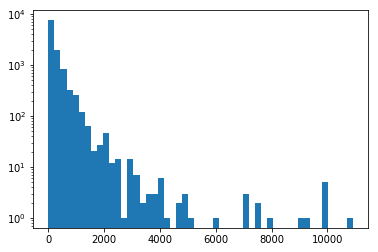

In [111]:
# What are the distribution of rental prices
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that I want to examine. However, if the rental is a large proporty it would not be fair to discriminate based on price alone. I'll look at price per person (price / accommodates) to look for outliers. 

In [112]:
# Create 'price_per_person' feature
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(10)

5000.000000    1
3000.000000    1
1750.000000    1
1500.000000    1
1250.000000    1
1090.000000    1
1000.000000    3
937.500000     1
875.000000     1
833.333333     2
Name: price_per_person, dtype: int64

In [113]:
df.loc[df['price_per_person'] > 1000.00]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
626,Private room,7000.0,4,1.0,1.0,f,78749,2,80.0,3,https://www.airbnb.com/rooms/925980,1750.0
4186,Entire home/apt,3000.0,1,NaN,NaN,f,78746,0,NaN,1,https://www.airbnb.com/rooms/11479152,3000.0
4200,Entire home/apt,2500.0,2,1.0,1.0,f,78701,0,NaN,1,https://www.airbnb.com/rooms/11493969,1250.0
4246,Private room,3000.0,2,1.5,1.0,t,78744,9,100.0,1,https://www.airbnb.com/rooms/11548720,1500.0
6454,Private room,10000.0,2,1.0,1.0,f,78723,0,NaN,1,https://www.airbnb.com/rooms/17607193,5000.0
9047,Entire home/apt,10900.0,10,3.0,4.0,t,78704,1,100.0,20,https://www.airbnb.com/rooms/22765762,1090.0


Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers. 

In [114]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1000.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

1000.000000    3
937.500000     1
875.000000     1
833.333333     2
800.000000     1
Name: price_per_person, dtype: int64

In [115]:
df.describe()

,price,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,price_per_person
count,11310.000000,11310.000000,11280.000000,11306.000000,11310.000000,11310.000000,8251.000000,11310.000000,11310.000000
mean,271.384527,4.511583,1.531649,1.777198,78721.954642,21.509461,96.235850,2.685146,57.882866
std,455.665751,2.934845,0.846767,1.222441,20.564282,45.652054,7.020309,8.396371,62.074328
min,0.000000,1.000000,0.000000,0.000000,78701.000000,0.000000,20.000000,1.000000,0.000000
25%,80.000000,2.000000,1.000000,1.000000,78704.000000,0.000000,95.000000,1.000000,25.000000
50%,150.000000,4.000000,1.000000,1.000000,78712.000000,4.000000,99.000000,2.000000,40.000000
75%,299.000000,6.000000,2.000000,2.000000,78744.000000,21.000000,100.000000,2.000000,66.666667
max,10000.000000,24.000000,13.500000,17.000000,78759.000000,645.000000,100.000000,365.000000,1000.000000


The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores **at the cost** of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [117]:
# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

Filling NaN 'review_scores_rating' with 96.236.


The bathrooms feature is missing some data. I'll update the NaNs based on a rough guess that for every 4 people the rental can accommodate, there is 1 bathroom. 

In [118]:
df[df['bathrooms'].isnull()].head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
81,Entire home/apt,95.0,2,NaN,1.0,t,78735,172,99.00000,3,https://www.airbnb.com/rooms/83322,47.500000
135,Entire home/apt,175.0,5,NaN,3.0,f,78723,1,80.00000,2,https://www.airbnb.com/rooms/247770,35.000000
159,Entire home/apt,350.0,4,NaN,2.0,f,78730,0,96.23585,4,https://www.airbnb.com/rooms/314152,87.500000
161,Entire home/apt,800.0,4,NaN,2.0,f,78701,2,60.00000,1,https://www.airbnb.com/rooms/315328,200.000000
163,Private room,125.0,3,NaN,1.0,f,78759,3,93.00000,1,https://www.airbnb.com/rooms/316885,41.666667


In [119]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
df['bathrooms'].fillna((df['accommodates']/4), inplace=True)

In [120]:
df.loc[[135]]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
135,Entire home/apt,175.0,5,1.25,3.0,f,78723,1,80.0,2,https://www.airbnb.com/rooms/247770,35.0


In [121]:
df.isnull().sum()

room_type                 0
price                     0
accommodates              0
bathrooms                 0
bedrooms                  4
host_is_superhost         3
neighbourhood_cleansed    0
number_of_reviews         0
review_scores_rating      0
minimum_nights            0
listing_url               0
price_per_person          0
dtype: int64

In [122]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US. 

In [123]:
df['bathrooms'].value_counts().sort_index(ascending=False)

13.50       1
11.50       1
9.50        1
8.50        1
8.00        4
7.50        4
7.00        4
6.50       10
6.00       11
5.50       19
5.00       42
4.50       51
4.00      115
3.50      206
3.00      412
2.50      781
2.00     2195
1.75        1
1.50      656
1.25        1
1.00     6724
0.75        4
0.50       32
0.25        3
0.00       24
Name: bathrooms, dtype: int64

In [124]:
df.groupby('bathrooms').price.median()

bathrooms
0.00        72.5
0.25       175.0
0.50        72.5
0.75       300.0
1.00       100.0
1.25       175.0
1.50       125.0
1.75      1000.0
2.00       236.0
2.50       315.0
3.00       500.0
3.50       675.0
4.00       773.0
4.50       979.0
5.00      1230.5
5.50      1379.0
6.00      1200.0
6.50      2375.0
7.00      1719.5
7.50      3565.0
8.00      1500.0
8.50      7000.0
9.50      1000.0
11.50    10000.0
13.50     1500.0
Name: price, dtype: float64

In [125]:
df['accommodates'].value_counts().sort_index(ascending=False)

24       1
21       2
20       3
18       5
16     148
15      26
14      45
13      17
12     143
11      36
10     379
9       97
8      743
7      277
6     1676
5      694
4     2238
3      971
2     3335
1      467
Name: accommodates, dtype: int64

In [126]:
df.groupby('accommodates').price.mean()

accommodates
1       83.432548
2      111.904948
3      147.360453
4      212.621537
5      274.217579
6      337.994033
7      393.350181
8      530.942127
9      526.030928
10     709.955145
11     710.861111
12     931.797203
13     609.705882
14     704.066667
15    1060.923077
16    1279.364865
18    3428.400000
20    5183.666667
21    2250.000000
24    2250.000000
Name: price, dtype: float64

In [127]:
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

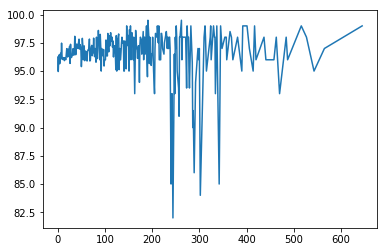

In [128]:
# Might be a moving average trend <100 reviews but data gets noisy >100 reviews
plt.plot(df.groupby('number_of_reviews').review_scores_rating.mean());

### Verify Data Quality

Need to verify that `price` is a float, `review_scores_rating` are not missing any values. 

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11288 entries, 0 to 11315
Data columns (total 12 columns):
room_type                 11288 non-null object
price                     11288 non-null float64
accommodates              11288 non-null int64
bathrooms                 11288 non-null float64
bedrooms                  11288 non-null float64
host_is_superhost         11288 non-null object
neighbourhood_cleansed    11288 non-null int64
number_of_reviews         11288 non-null int64
review_scores_rating      11288 non-null float64
minimum_nights            11288 non-null int64
listing_url               11288 non-null object
price_per_person          11288 non-null float64
dtypes: float64(5), int64(4), object(3)
memory usage: 1.1+ MB


***
# Data Preparation <a class="anchor" id="Data-Preparation"></a> 

The data preparation process in the CRISP-DM cycle consists of:
- Select your data 
- Clean your data
- Construct required data
- Integrate data (not required for this project)

### Select your data 
This is the stage of the project where you decide on the data that you're going to use for analysis. [[source]](https://www.sv-europe.com/crisp-dm-methodology/). To answer the business questions posed at the beginning, I'm choosing to keep the following features:

- 'price' - target feature for the business questions
- 'room_type' - property type: house, private room, shared room
- 'accommodates' - property size metric
- 'bathrooms' - property size metric
- 'bedrooms' - property size metric
- 'host_is_superhost' - Airbnb host status
- 'neighbourhood_cleansed' - Location, ZIP code
- 'number_of_reviews' - Review metric
- 'review_scores_rating' - Review metric
- 'minimum_nights' - length of stay metric

### Clean your data 
This task involves raise the data quality to the level required by the analysis techniques that you've selected [[source]](https://www.sv-europe.com/crisp-dm-methodology/). I'm creating a 'cleaning' function so that I don't have to repeat the above steps everytime I load the notebook. 

In [130]:
def clean_listings_data(csv, review_impute = True):
    '''
    Takes a listings.csv file (insideairbnb.com) for a particular
    city and outputs a cleaned the data frame 
    for the feature_list defined below. Note that the feature_list
    is hardcoded since the cleaning operations may not work for a
    different set of features. 
    
    Input:
    csv - insideairbnb.com listings.csv 
    review_impute - create additional DataFrames with no or '0' imputation 
                    for NaNs in the 'review_scores_rating' column
    
    Output:
    df - Cleaned DataFrame, used for prediction model
    df_no_impute - DataFrame with no imputed values on 'review_scores_rating'
    df_zeros_impute - DataFrame with integer '0' imputed values on 'review_scores_rating'
    '''
    
    # Import and load data
    df = pd.read_csv('listings_austin.csv')
    
    # Select features to keep in DataFrame
    feature_list = ['room_type', 'price', 'accommodates', 'bathrooms', 
                    'bedrooms', 'host_is_superhost', 'neighbourhood_cleansed', 
                    'number_of_reviews', 'review_scores_rating', 'minimum_nights']
    df = df[feature_list]
    
    # Convert price to from currency to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)
    
    # Create feature for price per person
    df['price_per_person'] = df['price']/df['accommodates']
    
    # Remove rows with > $1000 per person
    df = df.loc[df['price_per_person'] <= 1000.00]
    
    # df for specific plots - need data before 'review_scores_rating' imputation
    df_no_impute = df[['review_scores_rating', 'price', 'price_per_person', 
                    'number_of_reviews', 'bathrooms', 'bedrooms', 'accommodates']].copy()
    df_zeros_impute = df_no_impute.copy()
    df_no_impute.dropna(inplace=True)
    df_zeros_impute['review_scores_rating'].fillna(0, inplace=True)
    df_zeros_impute.dropna(inplace=True)

    # Imputed mean value of review scores to missing data in review_scores_rating feature
    df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)
    
    # Bathrooms is getting scaled later, so I do not care about making it a discrete value
    df['bathrooms'].fillna((df['accommodates']/4), inplace=True)
    
    # Drop the few remaining rows with missing values
    df.dropna(inplace=True)
    
    # Remove extremely large rental listing due to low samples
    df = df.loc[df['bathrooms'] <= 8]
    df = df.loc[df['accommodates'] <= 16]
    
    print('clean_listings_data: Cleaning Complete')
    
    if review_impute:
        return df, df_no_impute, df_zeros_impute
    else:
        return df

# Run cleanup function
df, df_no_impute, df_zeros_impute = clean_listings_data('listings_austin.csv')

clean_listings_data: Cleaning Complete


C:\Users\djcummin\anaconda3\envs\airbnb-austin-tx\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Construct required data

This task includes constructive data preparation operations such as the production of derived attributes or entire new records, or transformed values for existing attributes. [source](https://www.sv-europe.com/crisp-dm-methodology)

Now that the DataFrame is cleaned, I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. Also, for a different city, the following would need to be redone with the appropriate ZIP codes. 

Additionally, I need to create dummy variables and scale the features for the regression models. 

In [131]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [132]:
features_list = ['room_type', 'bathrooms', 'bedrooms', 'accommodates', 
                 'host_is_superhost',  'region', 'review_scores_rating', 'number_of_reviews']

# Create features and price DFs for sklearn inputs
features = df[features_list].copy()   # 'X'
price = df['price'].copy()            # 'y'

In [133]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,92.0,22,1,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,9,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,96.0,441,1,0,0,1,0,1,0,0,0,0
3,1.0,1.0,2,98.0,231,0,1,0,0,1,0,0,1,0,0
5,1.0,1.0,3,99.0,184,1,0,0,0,1,1,0,0,0,0


In [134]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'review_scores_rating', 'accommodates', 'number_of_reviews']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [135]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,0.250,0.2,0.200000,0.9000,0.034109,1,0,0,0,1,1,0,0,0,0
1,0.125,0.1,0.066667,0.8875,0.013953,0,1,0,0,1,1,0,0,0,0
2,0.125,0.1,0.133333,0.9500,0.683721,1,0,0,1,0,1,0,0,0,0
3,0.125,0.1,0.066667,0.9750,0.358140,0,1,0,0,1,0,0,1,0,0
5,0.125,0.1,0.133333,0.9875,0.285271,1,0,0,0,1,1,0,0,0,0


*** 
# 4. Modeling <a class="anchor" id="Modeling"></a>
The CRISP-DM modelling stage consists of:
- Select modeling technique
- Generate test design
- Build model
- Assess model

I want to look at the features of interest from the data understanding 'exploration' section and see if they can translate to a price prediction model.

### Select modeling technique

Because the vacation rental price (target) is a continuous variable, I want to select a regression model such as linear regression or a decision tree regressor. 

### Generate test design
I'm choosing to split the train and test sets with a 80/20% ratio using the sklearn `train_test_split` function where the 'y' target is rental price. 

In [136]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    price, 
                                                    test_size = .20, 
                                                    random_state = 10)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 9030 samples.
Testing set has 2258 samples.


### Build model
The below models will be exercised for the dataset and the r-squared score to be used as the model selection metric. 

In [137]:
# Models for comparison
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=100)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)

### Assess model
At this stage you should rank the models and assess them according to the evaluation criteria [source](https://www.sv-europe.com/crisp-dm-methodology/). In this case, I'm using the r-squared score since it describes goodness of fit of a model. As seen below, the RandomForestRegressor has the best r-squared result. 

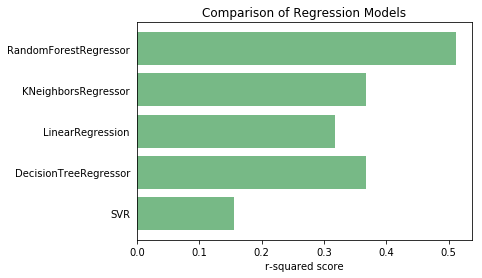

In [139]:
fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('images/compare_models.png', bbox_inches = 'tight')

***
# 5. Evaluation <a class="anchor" id="Evaluation"></a>

By the CRISP-DM definition, the evaluation step is used to assess the degree to which the model meets your business objectives and seek to determine if there is some business reason why this model is deficient. The evaluation phase also involves assessing any other data mining results you've generated. [source](https://www.sv-europe.com/crisp-dm-methodology)

Let's look back to the original business questions:
1. What regions of Austin, TX have the highest median rental price?
2. How do rental property size features relate to rental price?
3. How do review ratings relate to rental price?
4. What are the most important features in predicting rental price?

**Note:** The following plots required a lot of tweaking to get them into a format suitable for a blog post, hence it may look like there is a lack of plotting code re-use or an ignorance for DRY principles.

### 1. What regions of Austin, TX have the highest median rental price?

When compared by region, west Austin trends a bit higher than central in terms of median rental pricing. At first, I was a little surprised with the results, but I think there are likely reasons for this. West Austin is known for its sweeping views of the hill country, affluent communities, and an ideal location that is sandwiched between the popular Lake Travis area and downtown.

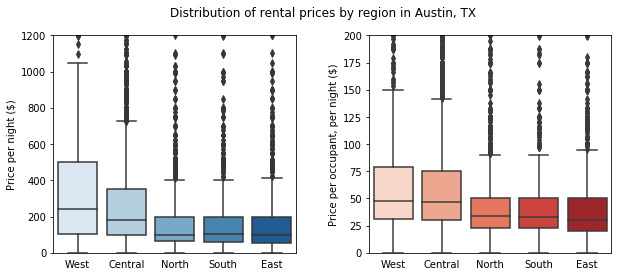

In [140]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=2)

order_list = ["West", "Central", "North", "South", "East"]

sns.boxplot(x="region", y="price", 
            order=order_list, 
            ax=ax[0], data=df, palette="Blues")
ax[0].set_ylabel("Price per night ($)")
ax[0].set_ylim(0, 1200)

sns.boxplot(x="region", y="price_per_person", 
            order=order_list, 
            ax=ax[1], data=df, palette="Reds")
ax[1].set_ylabel("Price per occupant, per night ($)")
ax[1].set_ylim(0, 200)

# DRY approach to loop over reused parameters
for a in ax:
    a.xaxis.label.set_visible(False)
    a.tick_params(axis='x', which='both', bottom=False, top=False) 

fig.suptitle("Distribution of rental prices by region in Austin, TX", fontsize=12)
fig.subplots_adjust(wspace=0.3)
fig.savefig('images/boxplot_price_region.png')

### 2. How do rental property size features relate to rental price?

Having established that the central and west regions of Austin have the highest median rental prices, I began to look at features related to property size. Since only a sparse amount of square footage data was available for the dataset, I figured that the number of bedrooms, bathrooms, and maximum occupants would be suitable metrics. As expected, there is a positive correlation between the median rental price versus the rental property size features.

C:\Users\djcummin\anaconda3\envs\airbnb-austin-tx\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


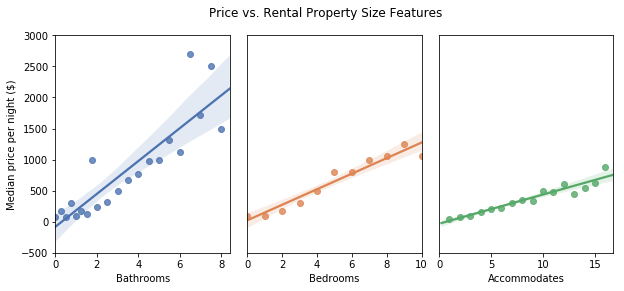

In [141]:
df_grp_bath = df.groupby('bathrooms').price.median().reset_index()
df_grp_bed = df.groupby('bedrooms').price.median().reset_index()
df_grp_acc = df.groupby('accommodates').price.median().reset_index()

fig, ax = plt.subplots(figsize=(10, 4), ncols=3)

# Create custom plot with same y-axis but different x-axes
sns.regplot(x='bathrooms', y='price', color='#4c72b0',
            data=df_grp_bath, ax=ax[0])
ax[0].set_xlim(0, None)
ax[0].set_xlabel("Bathrooms")
ax[0].set_ylabel("Median price per night ($)")

sns.regplot(x='bedrooms', y='price', color='#dd8452',
            data=df_grp_bed, ax=ax[1])
ax[1].set_xlim(0, 10)
ax[1].set_xlabel("Bedrooms")
ax[1].set_yticks([])
ax[1].yaxis.label.set_visible(False)

sns.regplot(x='accommodates', y='price', color='#55a868',
            data=df_grp_acc, ax=ax[2])
ax[2].set_xlim(0, None)
ax[2].set_xlabel("Accommodates")
ax[2].set_yticks([])
ax[2].yaxis.label.set_visible(False)

# DRY approach to loop over reused parameters
for a in ax:
    a.set_ylim(-500, 3000)
    a.tick_params(top=False, right=False) 

fig.suptitle("Price vs. Rental Property Size Features", fontsize=12)
fig.subplots_adjust(wspace=0.1)
fig.savefig('images/price_by_property_size.png')

In [142]:
# Print Pearson Correlation
for feat in ['bathrooms', 'bedrooms', 'accommodates']:
    df_temp = df.groupby(feat).price.median().reset_index()
    print('{} (corr, p-value) = {}'.format(feat, 
                                           pearsonr(df_temp['price'], df_temp[feat])))

bathrooms (corr, p-value) = (0.8772367089772577, 1.7877647924371563e-07)
bedrooms (corr, p-value) = (0.9667722764160025, 1.2398689564547642e-06)
accommodates (corr, p-value) = (0.9568929657691065, 6.6160742365413165e-09)


### 3. How do review ratings relate to rental price?

When plotting the price versus the review ratings, one can see that the majority of ratings are between 80–100. Along the same lines, rental prices of more than $900 are only found for properties with more than a review rating of 80. To pull in top dollar, it seems that the owners of more expensive rentals are making sure that the renters' expectations are being met.

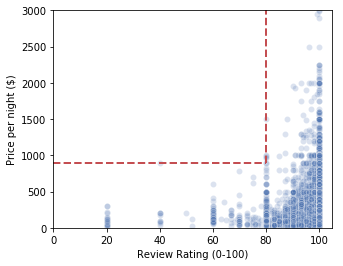

In [146]:
fig, ax = plt.subplots(figsize=(5, 4))

#https://stackoverflow.com/questions/38249454/extract-rgb-or-6-digit-code-from-seaborn-palette
sns.scatterplot(x="review_scores_rating", y='price',  
                data=df_no_impute, alpha=0.2, color='#4c72b0')
ax.set_ylim(1, 3000)
ax.set_xlim(0, 105)
ax.set_ylabel("Price per night ($)")
ax.set_xlabel("Review Rating (0-100)")
ax.tick_params(top=False) 
ax.vlines(x=80, ymin=900, ymax=3000, color = '#c44e52', 
          linestyle='--', linewidth=2)
ax.hlines(y=900, xmin=0, xmax=80, color = '#c44e52',
          linestyle='--', linewidth=2)
fig.savefig('images/ratings_vs_price.png')

In [147]:
# Print Pearson Correlation
print('(corr, p-value) = {}'.format(pearsonr(df_no_impute['price'], df_no_impute['review_scores_rating'])))

(corr, p-value) = (0.07546288539841538, 7.002977744322811e-12)


The price vs rating scatterplot is interesting, but how does the number of reviews factor in?

In [148]:
def f(row):
    if row['number_of_reviews'] == 0:
        val = '0 Reviews'
    elif row['number_of_reviews'] == 1:
        val = '1 Review'
    elif row['number_of_reviews'] == 2:
        val = '2 Reviews'
    else:
        val = '3 or more reviews'
    return val

# group number of reviews into 3 categories
df_no_imp['reviews_cat'] = df_no_imp.apply(f, axis=1)
print(df_no_imp['reviews_cat'].value_counts())
print(df_no_imp['reviews_cat'].value_counts()[1]/
      df_no_imp['reviews_cat'].value_counts().sum())

df_rating_median = df_no_imp.groupby('reviews_cat').median().reset_index()
df_rating_mean = df_no_imp.groupby('reviews_cat').mean().reset_index()

3 or more reviews    6465
0 Reviews            2905
1 Review             1213
2 Reviews             727
Name: reviews_cat, dtype: int64
0.2568523430592396


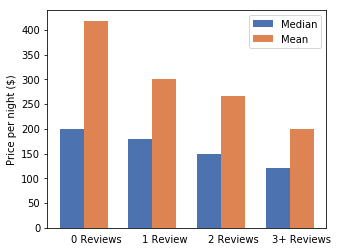

In [149]:
fig, ax = plt.subplots(figsize=(5, 4))

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,4)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, df_rating_median['price'], width, color='#4c72b0', alpha=1)
set_predict = ax.bar(pad+ind+width, df_rating_mean['price'], width, color='#dd8452')

ax.set_ylabel('Price per night ($)')
ax.set_xticks(pad + ind + width)
ax.set_ylim(0, None)
ax.set_xticklabels(['0 Reviews',
                    '1 Review',
                    '2 Reviews',
                    '3+ Reviews'])
ax.legend( (set_actual, set_predict), ('Median', 'Mean'), loc='upper right')
ax.tick_params(bottom=False, top=False, right=False)

fig.savefig('images/reviews_vs_price.png')

A surprising aspect of the dataset (at least for myself) was that there was a trend in decreasing price with an increase in the number of reviews. One-fourth of the rental listings did not have any reviews. The properties without reviews listed for more, on average, than the properties with reviews. Thinking about this, it is possible that lower and/or more competitively priced properties have a much higher throughput than their higher priced competitors. Maybe size is a factor? However, the data shows that the property size features are very constant with the number of reviews. Therefore, it is not the case that smaller properties are getting more reviews. It’s possible that properties that have been in the rental market longer have not increased in price over time. Or another factor may be that newer properties (fewer reviews) have updated renovations and expect more as a result.

In [150]:
# Interesting data, more reviews does not mean a 'smaller' property
df_no_imp.groupby('reviews_cat').mean().reset_index()

,reviews_cat,review_scores_rating,price,price_per_person,number_of_reviews,bathrooms,bedrooms,accommodates
0,0 Reviews,NaN,418.600000,89.877842,0.000000,1.590956,1.791667,4.404475
1,1 Review,94.808333,300.958780,65.997742,1.000000,1.565702,1.775763,4.334707
2,2 Reviews,96.086957,267.184319,58.896539,2.000000,1.513774,1.774415,4.353508
3,3 or more reviews,96.491019,200.157773,41.869612,37.216551,1.500774,1.771278,4.610673


### 4. What are the most important features in predicting rental price?

In [151]:
# RandomForestRegressor is selected model due to r2 score comparison earlier
reg_model = RandomForestRegressor(n_estimators=100)
reg_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [152]:
X_test.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
9797,0.2500,0.5,0.600000,0.750000,0.001550,1,0,0,1,0,1,0,0,0,0
4974,0.1250,0.1,0.066667,0.950000,0.043411,0,1,0,1,0,0,0,0,1,0
748,0.1875,0.1,0.066667,1.000000,0.175194,0,1,0,0,1,1,0,0,0,0
6062,0.1250,0.1,0.333333,0.952948,0.000000,1,0,0,1,0,1,0,0,0,0
4294,0.2500,0.3,0.400000,0.887500,0.106977,1,0,0,1,0,1,0,0,0,0


In [153]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
bathrooms,0.389924
number_of_reviews,0.163628
bedrooms,0.161785
accommodates,0.137611
review_scores_rating,0.034007
region_Central,0.033393
region_East,0.023171
region_West,0.013713
room_type_Entire home/apt,0.010723
host_is_superhost_t,0.009619


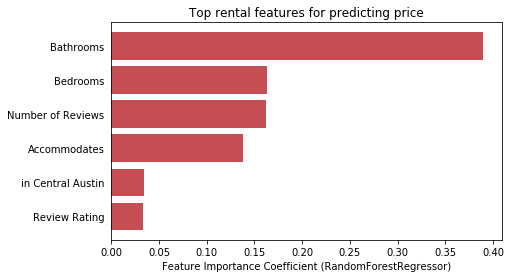

In [154]:
fig, ax = plt.subplots(figsize=(7, 4))

ind = range(0,6)
ax.barh(ind, feature_imp['importance'].values[0:6], 
        align='center', color='#c44e52', alpha=1)
ax.set_yticks(ind)
ax.set_yticklabels(['Bathrooms', 'Bedrooms', 'Number of Reviews', 'Accommodates', 
                    'in Central Austin', 'Review Rating'])
ax.set_title("Top rental features for predicting price")
ax.tick_params(left=False, top=False, right=False) 
ax.set_xlabel('Feature Importance Coefficient (RandomForestRegressor)')
plt.gca().invert_yaxis()
fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

Now I'm interested in predicting the prices for the first 8 rows of the dataset

In [155]:
features[:8]

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,92.0,22,1,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,9,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,96.0,441,1,0,0,1,0,1,0,0,0,0
3,1.0,1.0,2,98.0,231,0,1,0,0,1,0,0,1,0,0
5,1.0,1.0,3,99.0,184,1,0,0,0,1,1,0,0,0,0
7,2.0,2.0,5,94.0,40,1,0,0,1,0,1,0,0,0,0
8,2.0,3.0,6,98.0,22,1,0,0,1,0,0,0,0,1,0
9,1.0,1.0,2,98.0,79,0,1,0,0,1,0,1,0,0,0


In [156]:
price_actual = price[:8].values
price_predict = reg_model.predict(features_scaled[:8])
print(price_predict)

[137.92 128.6  106.71  38.93 122.05 230.34 269.81  48.65]


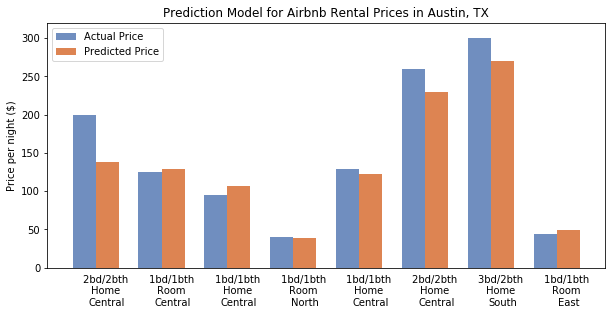

In [157]:
fig, ax = plt.subplots(figsize=(10, 4.5))

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,8)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, price_actual, width, color='#4c72b0', alpha=0.8)
set_predict = ax.bar(pad+ind+width, price_predict, width, color='#dd8452')

ax.set_ylabel('Price per night ($)')
ax.set_title('Prediction Model for Airbnb Rental Prices in Austin, TX')
ax.set_xticks(pad + ind + width)
ax.set_ylim(0, 320)
ax.set_xticklabels(['2bd/2bth \nHome \nCentral',
                    '1bd/1bth \nRoom \nCentral',
                    '1bd/1bth \nHome \nCentral',
                    '1bd/1bth \nRoom \nNorth',
                    '1bd/1bth \nHome \nCentral',
                    '2bd/2bth \nHome \nCentral',
                    '3bd/2bth \nHome \nSouth',
                    '1bd/1bth \nRoom \nEast'])
ax.legend( (set_actual, set_predict), ('Actual Price', 'Predicted Price'), 
          loc='upper left')
ax.tick_params(bottom=False, top=False, right=False)

fig.savefig('images/predict_compare.png')

# 6. Deployment <a class="anchor" id="Deployment"></a>

In the deployment stage you'll take your evaluation results and determine a strategy for their deployment. [Source](https://www.sv-europe.com/crisp-dm-methodology) 

I've accomplished what I wanted for this notebook, but a real life team could iterate on additional questions that arose from the study such as NLP for ratings prediction and tweaking other aspects of the prediction model. 